<a href="https://colab.research.google.com/github/ikoojos/Algorithm-Debt-Research/blob/master/Instructor_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
from google.colab import drive
from itertools import product
from sklearn.linear_model import LogisticRegression
import importlib


import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


# Mount Google Drive
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/AD Final Experiments')

# Import custom modules
from preprocessing import preprocess_data
from splitting import split_data
from utils import *
from evaluate_model import evaluate_best_model
from lr_tuning import hyperparameter_tuning


for module in ['preprocessing', 'splitting', 'utils', 'evaluate_model', 'lr_tuning']:
    importlib.reload(sys.modules[module])


Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/AD Final Experiments'
!pip install -r requirements.txt

/content/drive/My Drive/AD Final Experiments
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.4 MB/s eta 0:00:00
  Created wheel for sentence-transf

In [ ]:
!pip install sentence-transformers
!pip install InstructorEmbedding

In [ ]:
!pip install --upgrade huggingface_hub
!pip install huggingface_hub==0.25.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.1/464.1 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.27.1
    Uninstalling huggingface-hub-0.27.1:
      Successfully uninstalled huggingface-hub-0.27.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.28.1
    Uninstalling huggingface-hub-0.28.1:
      Successfully uninstalled huggingface-hub-0.28.1


In [ ]:
drive.mount('/content/drive')

sys.path.append('/content/drive/My Drive/AD Final Experiments')

file_path = '/content/drive/My Drive/AD Identification using SATD/liu_datset_processed.csv'
data = preprocess_data(file_path)
#X_train_final, X_val, X_test, y_train_final, y_val, y_test = split_data(data)

print("Data preprocessing complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data preprocessing complete!


In [ ]:
from InstructorEmbedding import INSTRUCTOR

model = INSTRUCTOR('hkunlp/instructor-large')
liu_data = data

class_mapping = {label: idx for idx, label in enumerate(liu_data['TDType'].unique())}
liu_data['label'] = liu_data['TDType'].map(class_mapping)

X_train, X_test, y_train, y_test = train_test_split(liu_data['Comments'], liu_data['label'], test_size=0.2, random_state=42)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


def prepare_text_instruction_pairs(texts):
    instruction = "Represent the following technical debt comments for classification:"
    return [[instruction, text] for text in texts]

train_texts = prepare_text_instruction_pairs(X_train_final.tolist())
val_texts = prepare_text_instruction_pairs(X_val.tolist())
test_texts = prepare_text_instruction_pairs(X_test.tolist())

# Generate Embeddings
def calculate_embeddings(model, texts):
    return model.encode(texts)

train_embeddings = calculate_embeddings(model, train_texts)
val_embeddings = calculate_embeddings(model, val_texts)
test_embeddings = calculate_embeddings(model, test_texts)

train_df = pd.DataFrame(train_embeddings)
train_df['label'] = y_train_final.values

val_df = pd.DataFrame(val_embeddings)
val_df['label'] = y_val.values

test_df = pd.DataFrame(test_embeddings)
test_df['label'] = y_test.values

# Save to CSV
train_df.to_csv('train_embeddings__.csv', index=False)
val_df.to_csv('val_embeddings__.csv', index=False)
test_df.to_csv('test_embeddings__.csv', index=False)

print("Embeddings__ for Train, Validation, and Test sets have been saved.")


.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512
Embeddings__ for Train, Validation, and Test sets have been saved.


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from itertools import product
import warnings

# Load Precomputed Embeddings
train_df = pd.read_csv('train_embeddings__.csv')
val_df = pd.read_csv('val_embeddings__.csv')
test_df = pd.read_csv('test_embeddings__.csv')

# Separate Features (X) and Labels (y)
X_train, y_train = train_df.iloc[:, :-1], train_df['label']
X_val, y_val = val_df.iloc[:, :-1], val_df['label']
X_test, y_test = test_df.iloc[:, :-1], test_df['label']

param_grid = {
    'C': [0.01, 1, 10],
    'penalty': ['l2'],  # Regularization (ElasticNet is not supported for dense embeddings)
    'max_iter': [100, 200]
}

# Initialize Variables to Track the Best Model
best_score = -1
best_params = None
best_model = None

# Hyperparameter Tuning Loop
for C, penalty, max_iter in product(param_grid['C'], param_grid['penalty'], param_grid['max_iter']):
    solver = 'lbfgs'  # Solver suitable for 'l2' regularization

    try:
        # Build Pipeline with StandardScaler and Logistic Regression
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(
                C=C, penalty=penalty, max_iter=max_iter, solver=solver,
                random_state=42, class_weight='balanced'
            ))
        ])


        pipeline.fit(X_train, y_train)

        # Validate the Model on the Validation Set
        y_val_pred = pipeline.predict(X_val)
        score = accuracy_score(y_val, y_val_pred)

        # Update the Best Model if Current Validation Score is Higher
        if score > best_score:
            best_score = score
            best_params = {'C': C, 'penalty': penalty, 'max_iter': max_iter}
            best_model = pipeline

    except Exception as e:
        print(f"Skipping configuration C={C}, penalty={penalty}, max_iter={max_iter} due to error: {e}")

# Evaluate the Best Model on the Test Set
if best_model:
    y_test_pred = best_model.predict(X_test)

    print("Best Model Parameters:", best_params)
    print("Validation Accuracy of Best Model:", best_score)

    print("\nTest Set Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("F1 Score:", f1_score(y_test, y_test_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_test_pred))
else:
    print("No valid model was found during hyperparameter tuning.")


Best Model Parameters: {'C': 10, 'penalty': 'l2', 'max_iter': 200}
Validation Accuracy of Best Model: 0.7827974276527331

Test Set Evaluation:
Accuracy: 0.7747909967845659
F1 Score: 0.7972773370319105
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.52      0.29       200
           1       0.22      0.52      0.31        89
           2       0.24      0.45      0.31       135
           3       0.79      0.62      0.69      2206
           4       0.25      0.61      0.35        23
           5       0.42      0.65      0.51       387
           6       0.51      0.64      0.57       143
           7       0.96      0.89      0.93      4592

    accuracy                           0.77      7775
   macro avg       0.45      0.61      0.50      7775
weighted avg       0.84      0.77      0.80      7775



In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from itertools import product
import warnings

# Load Precomputed Embeddings
train_df = pd.read_csv('train_embeddings__.csv')
val_df = pd.read_csv('val_embeddings__.csv')
test_df = pd.read_csv('test_embeddings__.csv')

# Separate Features (X) and Labels (y)
X_train, y_train = train_df.iloc[:, :-1], train_df['label']
X_val, y_val = val_df.iloc[:, :-1], val_df['label']
X_test, y_test = test_df.iloc[:, :-1], test_df['label']

param_grid = {
    'C': [0.01, 1, 10],
    'penalty': ['l2'],  # Regularization (ElasticNet is not supported for dense embeddings)
    'max_iter': [100, 200]
}

# Initialize Variables to Track the Best Model
best_score = -1
best_params = None
best_model = None

# Hyperparameter Tuning Loop
for C, penalty, max_iter in product(param_grid['C'], param_grid['penalty'], param_grid['max_iter']):
    solver = 'lbfgs'  # Solver suitable for 'l2' regularization

    try:
        # Build Pipeline with StandardScaler and Logistic Regression
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(
                C=C, penalty=penalty, max_iter=max_iter, solver=solver,
                random_state=42, class_weight='balanced'
            ))
        ])


        pipeline.fit(X_train, y_train)

        # Validate the Model on the Validation Set
        y_val_pred = pipeline.predict(X_val)
        score = accuracy_score(y_val, y_val_pred)

        # Update the Best Model if Current Validation Score is Higher
        if score > best_score:
            best_score = score
            best_params = {'C': C, 'penalty': penalty, 'max_iter': max_iter}
            best_model = pipeline

    except Exception as e:
        print(f"Skipping configuration C={C}, penalty={penalty}, max_iter={max_iter} due to error: {e}")

# Evaluate the Best Model on the Test Set
if best_model:
    y_test_pred = best_model.predict(X_test)

    print("Best Model Parameters:", best_params)
    print("Validation Accuracy of Best Model:", best_score)

    print("\nTest Set Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("F1 Score:", f1_score(y_test, y_test_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_test_pred))
else:
    print("No valid model was found during hyperparameter tuning.")


Best Model Parameters: {'C': 10, 'penalty': 'l2', 'max_iter': 200}
Validation Accuracy of Best Model: 0.7844051446945337

Test Set Evaluation:
Accuracy: 0.7758199356913184
F1 Score: 0.7978434750081256
Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.51      0.29       200
           1       0.22      0.52      0.31        89
           2       0.24      0.45      0.31       135
           3       0.79      0.62      0.69      2206
           4       0.25      0.61      0.36        23
           5       0.42      0.65      0.51       387
           6       0.50      0.64      0.56       143
           7       0.96      0.89      0.93      4592

    accuracy                           0.78      7775
   macro avg       0.45      0.61      0.50      7775
weighted avg       0.84      0.78      0.80      7775



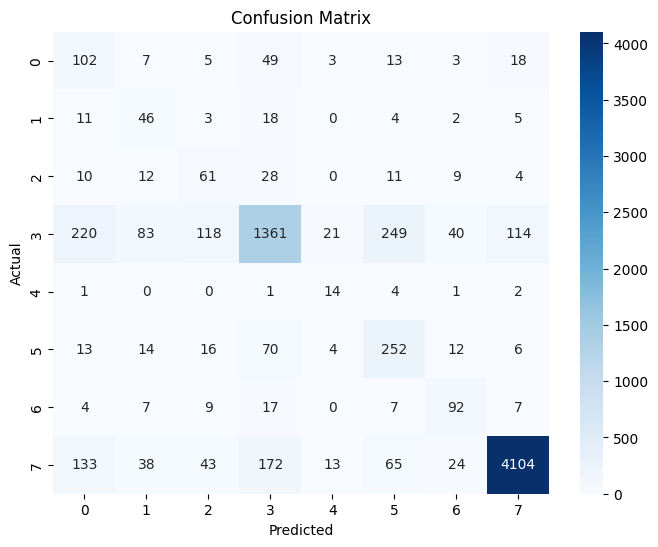

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(cm)

[[ 102    7    5   49    3   13    3   18]
 [  11   46    3   18    0    4    2    5]
 [  10   12   61   28    0   11    9    4]
 [ 220   83  118 1361   21  249   40  114]
 [   1    0    0    1   14    4    1    2]
 [  13   14   16   70    4  252   12    6]
 [   4    7    9   17    0    7   92    7]
 [ 133   38   43  172   13   65   24 4104]]
